# Importing Packages / Setting Up

In [1]:
# mounting Google Drive for consolidated file storage
# skip this step if directly importing files
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Senior/Thesis/Data/

Mounted at /content/drive
/content/drive/My Drive/Senior/Thesis/Data


In [2]:
# installing tslearn for time series clustering
!pip install tslearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 3.1 MB/s eta 0:00:00


In [3]:
# importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
from datetime import datetime
import requests

# Data Scraping

In [ ]:
# setup for item price data scraping

# cookie is required to scrape data, requires a Steam account
# to get cookie code, inspect element on steampowered.com, >>, application, storage, cookies, steamLoginSecure
cookie_code = '76561198140284667%7C%7CeyAidHlwIjogIkpXVCIsICJhbGciOiAiRWREU0EiIH0.eyAiaXNzIjogInI6MEU2Rl8yM0VDNjY1OV8xQ0E4NiIsICJzdWIiOiAiNzY1NjExOTgxNDAyODQ2NjciLCAiYXVkIjogWyAid2ViOnN0b3JlIiBdLCAiZXhwIjogMTcxMTQ2Mjk3NiwgIm5iZiI6IDE3MDI3MzYwNDAsICJpYXQiOiAxNzExMzc2MDQwLCAianRpIjogIjBFQzlfMjQyNzhBODRfRDMxMzIiLCAib2F0IjogMTcwNzc4NjkzOSwgInJ0X2V4cCI6IDE3MjYwNTk2MTMsICJwZXIiOiAwLCAiaXBfc3ViamVjdCI6ICIxNDAuMTgwLjI0MC45NCIsICJpcF9jb25maXJtZXIiOiAiMTQwLjE4MC4yNDAuMTExIiB9.kl2lgGmKoCfT6RqYh9KH_talqu6vA0vjpFRyRitu0kl-yOfN537ldLakouiiaKOhenWLBoP9C8TDLIjESEDrAw'
cookie = {'steamLoginSecure': cookie_code}

# to get url of specific item

# country = US -- 2 letter ISO country code
# currency = 1 -- 1 for USD, 3 for EUR
# appid = 730 -- CSGO (now CS2) has id 730
# market_hash_name = 'Falchion%20Case' -- name of item on the market

# https://steamcommunity.com/market/listings/730/AK-47%20%7C%20Redline%20%28Field-Tested%29 -- URL for "AK-47 | Redline (Field-Tested)"

# in the price query:
# first item is date
# second item is median sale price
# third item is volume sold

In [ ]:
# for data on price dates over the past month, it tracks every hour, whereas anything before only tracks one per day (at 01: +0)

# fnsure of what "01: +0" means in the date (assuming hour: + minutes), but not necessary for analysis
# May 27 2015 01: +0
input_format = '%b %d %Y %H: +%M'

announce = datetime(2023, 3, 22)
release = datetime(2023, 9, 27)

In [ ]:
# Converts the item name to the market hash name needed for the URL
# Typical item name: "P250 | Valence (Battle-Scarred)""
# StatTrak weapon name: "StatTrak™ AWP | Redline (Field-Tested)"
# Typical weapon name: "★ Shadow Daggers | Gamma Doppler (Minimal Wear)"
# StatTrak knife name: "★ StatTrak™ Gut Knife | Doppler (Factory New)"

# symbols come from ascii table, symbols to hex
# symbols come from unicode characters, symbols to UTF-8 hex
# --> all UTF-8 hex??? all characters get translated except for letters and '-'
# ' ' -- %20
# '&' -- %26
# ''' -- %27
# '(' -- %28
# ')' -- %29
# '+' -- %2B
# ',' -- %2C
# ':' -- %3A
# '|' -- %7C
# 'ö' -- %C3%B6
# '™' -- %E2%84%A2
# '★' -- %E2%98%85
# '♥' -- %E2%99%A5
# '壱' -- %E5%A3%B1
# '弐' -- %E5%BC%90
# '王' -- %E7%8E%8B
# '脸' -- %E8%84%B8
# '花' -- %E8%8A%B1
# '龍' -- %E9%BE%8D
def marketHashName(item):
    string = item.replace(" ", "%20")
    string = string.replace("&", "%26")
    string = string.replace("'", "%27")
    string = string.replace("(", "%28")
    string = string.replace(")", "%29")
    string = string.replace("+", "%2B")
    string = string.replace(",", "%2C")
    string = string.replace(":", "%3A")
    string = string.replace("|", "%7C")
    string = string.replace("ö", "%C3%B6")
    string = string.replace("™", "%E2%84%A2")
    string = string.replace("★", "%E2%98%85")
    string = string.replace("♥", "%E2%99%A5")
    string = string.replace("壱", "%E5%A3%B1")
    string = string.replace("弐", "%E5%BC%90")
    string = string.replace("王", "%E7%8E%8B")
    string = string.replace("脸", "%E8%84%B8")
    string = string.replace("花", "%E8%8A%B1")
    string = string.replace("龍", "%E9%BE%8D")
    return string

# returns the URL of the item's price history
def getURL(item):
    market_hash_name = marketHashName(item)
    url = f"http://steamcommunity.com/market/pricehistory/?country=US&currency=1&appid=730&market_hash_name={market_hash_name}"
    return url

# returns a DataFrame object for daily price history along with the volume sold each day
def getDailyDF(item):
    url = getURL(item)
    response = requests.get(url, cookies=cookie)
    data = response.json()

    if data['success']:
        prices_info = np.array(data['prices'])
        all_dates = prices_info[:,0]
        all_prices = prices_info[:,1]
        all_volume = prices_info[:,2]
        print(item)
    else:
        # print(item)
        raise Exception("Incorrect item name.")

    dates = np.array([])
    prices = np.array([])
    volumes = np.array([])
    for i in range(len(all_dates)):
        if datetime.strptime(all_dates[i], input_format).hour == 1:
            dates = np.append(dates, datetime.strptime(all_dates[i], input_format).date())
            prices = np.append(prices, all_prices[i])
            volumes = np.append(volumes, all_volume[i])

    prices = prices.astype('float64')
    volumes = volumes.astype('int64')

    df = pd.DataFrame()
    df['Price ($)'] = prices
    df['Volume'] = volumes
    df = df.set_index(dates)

    return df

In [ ]:
# loading text file of item names to read:
def readFile(file):
    df = pd.read_csv(file, header=None)
    names = df.to_numpy().squeeze()
    return names

# joining prices and volumes together for a list of item names
def getPriceVolume(names):
    price_df = pd.DataFrame()
    volume_df = pd.DataFrame()
    for i in range(len(names)):
        item = getDailyDF(names[i])
        prices = pd.DataFrame(item.iloc[:,0])
        volumes = pd.DataFrame(item.iloc[:,1])
        price_df = price_df.join(prices, how='outer').rename(columns={"Price ($)": names[i]})
        volume_df = volume_df.join(volumes, how='outer').rename(columns={"Volume": names[i]})
    return price_df, volume_df

# downloading data to .csv files given names if the items
def downloadSegmentedData(nameFile):
    content = nameFile.replace('Names.txt','')
    names = readFile(nameFile)
    prices, volumes = getPriceVolume(names)
    prices.to_csv(content + "Prices.csv")
    volumes.to_csv(content + "Volumes.csv")

def downloadData(itemNames, chunk):
    prices, volumes = getPriceVolume(itemNames)
    prices.to_csv(chunk + "Prices.csv")
    volumes.to_csv(chunk + "Volumes.csv")

In [ ]:
# importing item data
data = pd.read_csv("ItemFeatures.csv", index_col=0)
itemNames = list(data.index)

# splitting up the data into smaller clusters to download more effectively
cluster1 = itemNames[:5000]
cluster2 = itemNames[5000:10000]
cluster3 = itemNames[10000:15000]
cluster4 = itemNames[15000:]

In [ ]:
# downloading the dataset through clusters
# data gathered as of 12/14/2023
downloadData(cluster1, "cluster1")
downloadData(cluster2, "cluster2")
downloadData(cluster3, "cluster3")
downloadData(cluster4, "cluster4")

In [ ]:
# merging clustered data into one consildated file

# item prices
price1 = pd.read_csv("cluster1Prices.csv", index_col=0)
price2 = pd.read_csv("cluster2Prices.csv", index_col=0)
price3 = pd.read_csv("cluster3Prices.csv", index_col=0)
price4 = pd.read_csv("cluster4Prices.csv", index_col=0)
price = price1.join(price2, how='outer').join(price3, how='outer').join(price4, how='outer')
price.to_csv("Prices.csv")

# item volumes
volume1 = pd.read_csv("cluster1Volumes.csv", index_col=0)
volume2 = pd.read_csv("cluster2Volumes.csv", index_col=0)
volume3 = pd.read_csv("cluster3Volumes.csv", index_col=0)
volume4 = pd.read_csv("cluster4Volumes.csv", index_col=0)
volume = volume1.join(volume2, how='outer').join(volume3, how='outer').join(volume4, how='outer')
volume.to_csv("Volumes.csv")

# Item Features

In [ ]:
features = pd.read_csv("ItemFeatures_Dec07.csv")

# useful features contained in this dataset
features.columns

Index(['markethashname', 'color', 'bordercolor', 'unstable', 'unstablereason',
       'offervolume', 'sold24h', 'sold7d', 'sold30d', 'sold90d', 'wear',
       'itemgroup', 'itemtype', 'rarity', 'quality', 'isstattrack', 'isstar'],
      dtype='object')

In [ ]:
features

markethashname   color bordercolor  \
0                 'Blueberries' Buckshot | NSWC SEAL  8847ff      d2d2d2   
1       'Medium Rare' Crasswater | Guerrilla Warfare  eb4b4b      d2d2d2   
2                       'The Doctor' Romanov | Sabre  eb4b4b      d2d2d2   
3                   'Two Times' McCoy | TACP Cavalry  d32ce6      d2d2d2   
4                      'Two Times' McCoy | USAF TACP  d32ce6      d2d2d2   
...                                              ...     ...         ...   
20390  ★ Ursus Knife | Urban Masked (Battle-Scarred)  eb4b4b      8650ac   
20391     ★ Ursus Knife | Urban Masked (Factory New)     NaN      8650ac   
20392    ★ Ursus Knife | Urban Masked (Field-Tested)  eb4b4b      8650ac   
20393    ★ Ursus Knife | Urban Masked (Minimal Wear)  eb4b4b      8650ac   
20394       ★ Ursus Knife | Urban Masked (Well-Worn)  eb4b4b      8650ac   

       unstable          unstablereason  offervolume  sold24h  sold7d  \
0             0                     NaN        155.0       59     512   
1             0                     NaN        153.0       87     435   
2             0                     NaN        567.0      227    1556   
3             0                     NaN        435.0      251    1553   
4             0                     NaN        679.0      552    2600   
...         ...                     ...          ...      ...     ...   
20390         1  LOW_SALES_3PLUS_MONTHS          2.0        0       3   
20391         1  LOW_SALES_3PLUS_MONTHS          2.0        0       0   
20392         1         LOW_SALES_MONTH         12.0        2      11   
20393         1  LOW_SALES_3PLUS_MONTHS          3.0        1       2   
20394         1  LOW_SALES_3PLUS_MONTHS          4.0        0       2   

       sold30d  sold90d wear itemgroup                  itemtype       rarity  \
0         2841    12144  NaN     agent    'blueberries' buckshot  exceptional   
1         2357     8654  NaN     agent  'medium rare' crasswater       master   
2         9216    36857  NaN     agent      'the doctor' romanov       master   
3         7504    31540  NaN     agent         'two times' mccoy     superior   
4        10873    45491  NaN     agent         'two times' mccoy     superior   
...        ...      ...  ...       ...                       ...          ...   
20390       27      110   bs     knife               ursus knife       covert   
20391        1        2   fn       NaN                       NaN          NaN   
20392       78      323   ft     knife               ursus knife       covert   
20393       21       81   mw     knife               ursus knife       covert   
20394       16       65   ww     knife               ursus knife       covert   

       quality  isstattrack  isstar  
0       normal            0       0  
1       normal            0       0  
2       normal            0       0  
3       normal            0       0  
4       normal            0       0  
...        ...          ...     ...  
20390  unusual            0       1  
20391      NaN            0       1  
20392  unusual            0       1  
20393  unusual            0       1  
20394  unusual            0       1  

[20395 rows x 17 columns]

In [ ]:
print("# unstable reason being low_sales_month:", len(features[features["unstablereason"] == "LOW_SALES_MONTH"]))
print("# unstable reason being low_sales_week:", len(features[features["unstablereason"] == "LOW_SALES_WEEK"]))
print("# stable market items:", len(features[features["unstable"] == 0]))
print("# 24h sold volume >= 1:", len(features[features["sold24h"] >= 1]))
print("# 24h sold volume >= 5:", len(features[features["sold24h"] >= 5]))
print("# 24h sold volume >= 10:", len(features[features["sold24h"] >= 10]))
print("# 7d sold volume >= 20:", len(features[features["sold7d"] >= 20]))

# unstable reason being low_sales_month: 2473
# unstable reason being low_sales_week: 3096
# stable market items: 7784
# 24h sold volume >= 1: 14919
# 24h sold volume >= 5: 10108
# 24h sold volume >= 10: 8041
# 7d sold volume >= 20: 11416


# Prices

In [ ]:
# reading data from downloaded csv format from DataCollection.ipynb
# viewing time period starting from 1/1/2023
price = pd.read_csv("Prices.csv", index_col=0)["2023":]
volume = pd.read_csv("Volumes.csv", index_col=0)["2023":]

In [ ]:
price

'Blueberries' Buckshot | NSWC SEAL  \
2023-01-01                               2.593   
2023-01-02                               2.704   
2023-01-03                               2.620   
2023-01-04                               2.674   
2023-01-05                               2.713   
...                                        ...   
2023-12-11                              11.051   
2023-12-12                              10.550   
2023-12-13                              10.780   
2023-12-14                              11.245   
2023-12-15                                 NaN   

            'Medium Rare' Crasswater | Guerrilla Warfare  \
2023-01-01                                         6.806   
2023-01-02                                         6.990   
2023-01-03                                         6.834   
2023-01-04                                         6.893   
2023-01-05                                         7.105   
...                                                  ...   
2023-12-11                                        15.375   
2023-12-12                                           NaN   
2023-12-13                                        15.690   
2023-12-14                                           NaN   
2023-12-15                                           NaN   

            'The Doctor' Romanov | Sabre  'Two Times' McCoy | TACP Cavalry  \
2023-01-01                         3.805                             1.732   
2023-01-02                         3.844                             1.713   
2023-01-03                         3.781                             1.719   
2023-01-04                         3.798                             1.677   
2023-01-05                         3.823                             1.724   
...                                  ...                               ...   
2023-12-11                         7.440                             1.031   
2023-12-12                         7.650                             3.955   
2023-12-13                         7.535                             3.910   
2023-12-14                         7.313                             1.035   
2023-12-15                           NaN                               NaN   

            'Two Times' McCoy | USAF TACP  10 Year Birthday Sticker Capsule  \
2023-01-01                          1.683                             1.012   
2023-01-02                          1.701                             1.042   
2023-01-03                          1.672                             1.000   
2023-01-04                          1.662                             1.036   
2023-01-05                          1.667                             1.007   
...                                   ...                               ...   
2023-12-11                          2.111                             0.877   
2023-12-12                          3.757                             0.870   
2023-12-13                          0.924                             0.861   
2023-12-14                          2.241                             0.860   
2023-12-15                            NaN                               NaN   

            1st Lieutenant Farlow | SWAT  2020 RMR Challengers  \
2023-01-01                         3.036                 0.179   
2023-01-02                         3.076                 0.178   
2023-01-03                         3.081                 0.172   
2023-01-04                         3.146                 0.170   
2023-01-05                         3.257                 0.170   
...                                  ...                   ...   
2023-12-11                         5.345                 0.289   
2023-12-12                         6.125                 0.307   
2023-12-13                         5.750                 0.304   
2023-12-14                         5.920                 0.287   
2023-12-15                           NaN                   NaN   

           

### Stable Items

In [ ]:
# filtering working data set
stable = features[features["unstable"] == 0]
stable_names = features[features["unstable"] == 0]["markethashname"].to_list()
stable_data = price.filter(items=stable_names)

In [ ]:
# function to get any specified feature of an item given its name
def get_feature(item, feature, database):
    return database[database.markethashname == item][feature].item()

In [ ]:
stable['itemgroup'].value_counts()

sticker         1789
pistol          1556
smg             1076
rifle           1043
graffiti         740
shotgun          543
sniper rifle     486
machinegun       193
container        129
music kit         81
agent             63
patch             28
gloves            23
collectible       22
knife              5
pass               2
key                2
gift               1
tool               1
Name: itemgroup, dtype: int64

In [ ]:
stable['rarity'].value_counts()

mil-spec grade      1927
restricted          1197
high grade          1094
base grade           846
consumer grade       592
remarkable           553
classified           520
industrial grade     372
covert               294
exotic               256
extraordinary         69
exceptional           16
master                16
distinguished         16
superior              15
Name: rarity, dtype: int64

In [ ]:
stable['quality'].value_counts()

normal        6012
strange       1408
tournament     335
unusual         28
Name: quality, dtype: int64

In [ ]:
stable_data.shape

(349, 7784)

In [ ]:
X_train = TimeSeriesScalerMeanVariance().fit_transform(stable_data.T)
X_train.shape

(7784, 349, 1)

In [ ]:
y_train = np.array([get_feature(name, 'rarity', stable) for name in stable_data.columns])
y_train.shape

(7784,)

In [ ]:
plt.rcParams['figure.figsize'] = [12, 5]

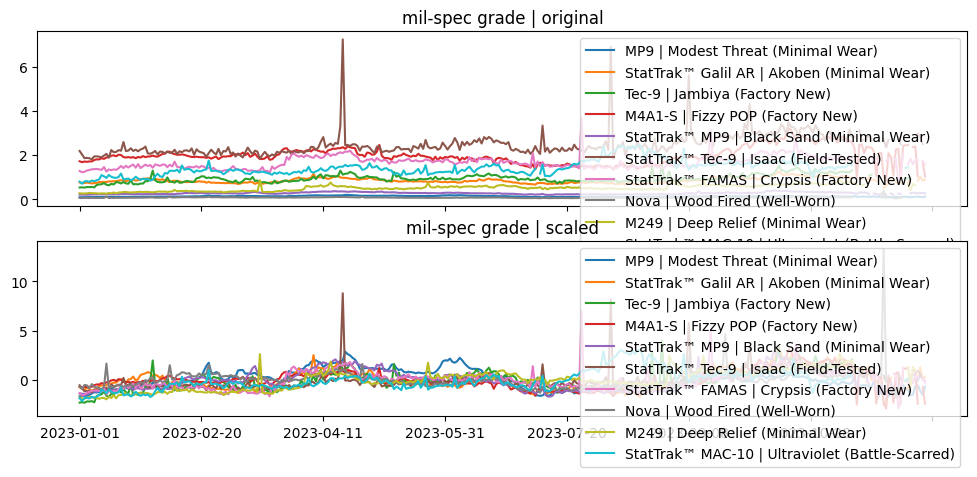

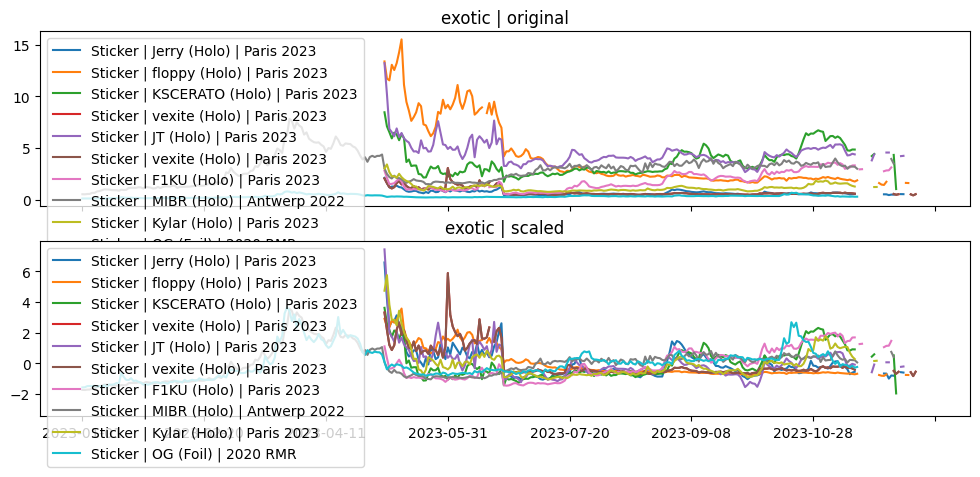

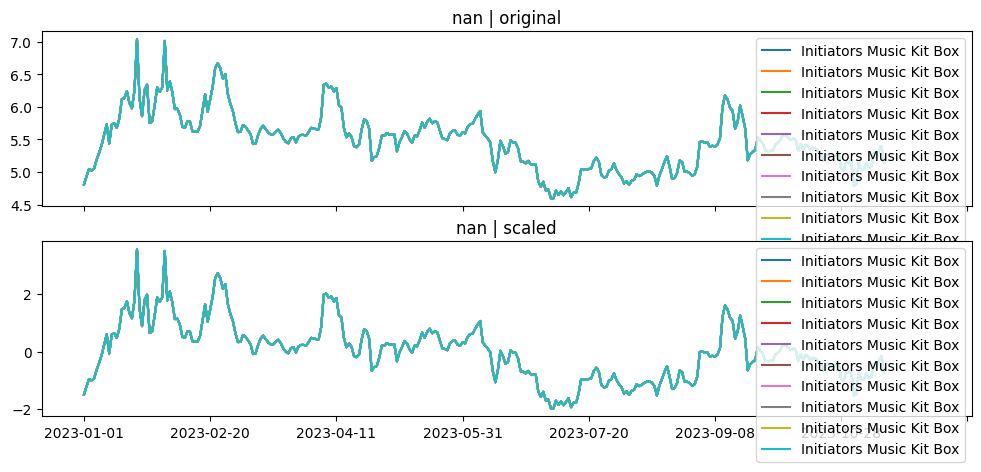

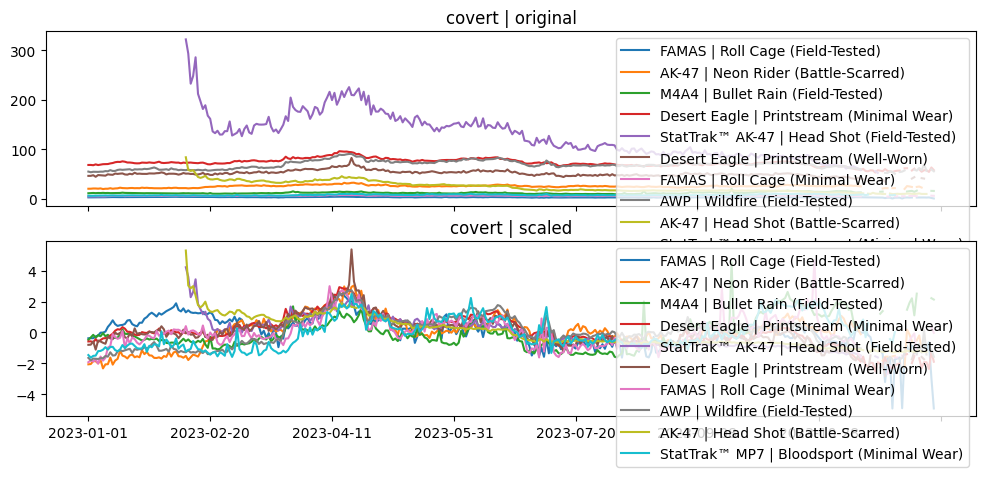

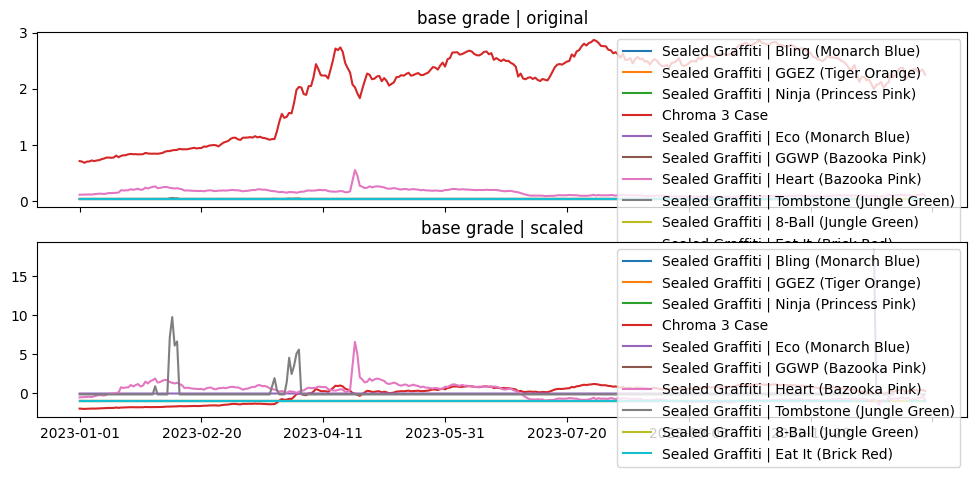

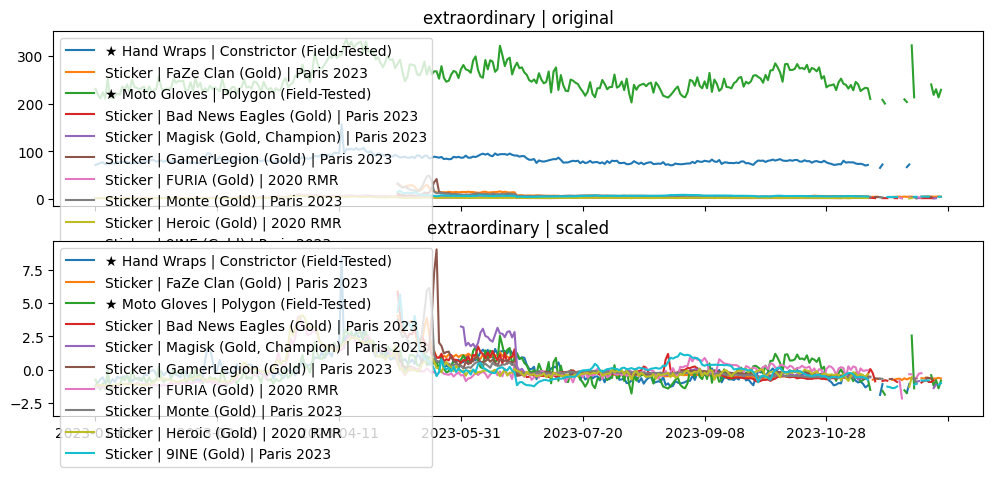

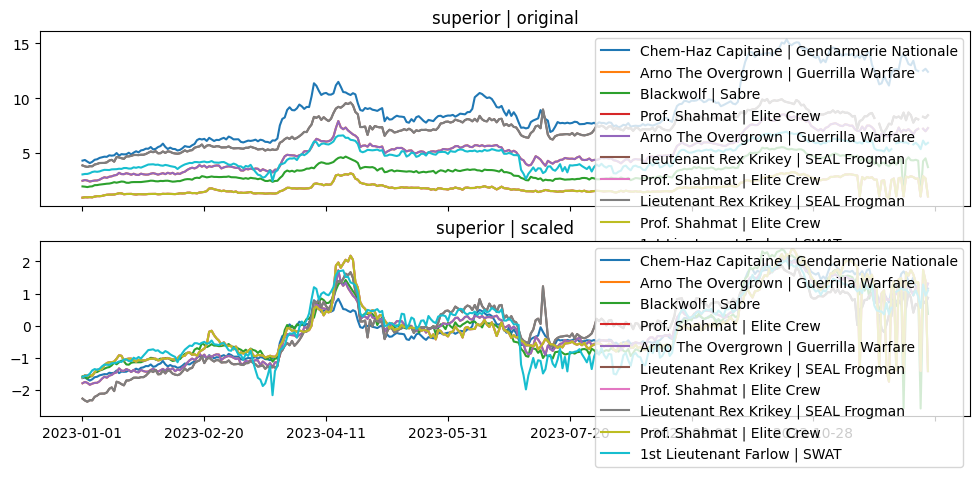

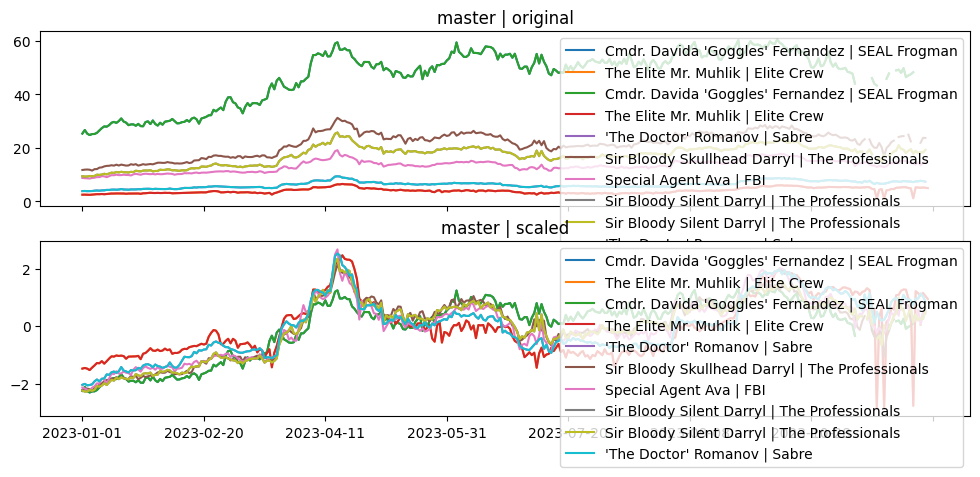

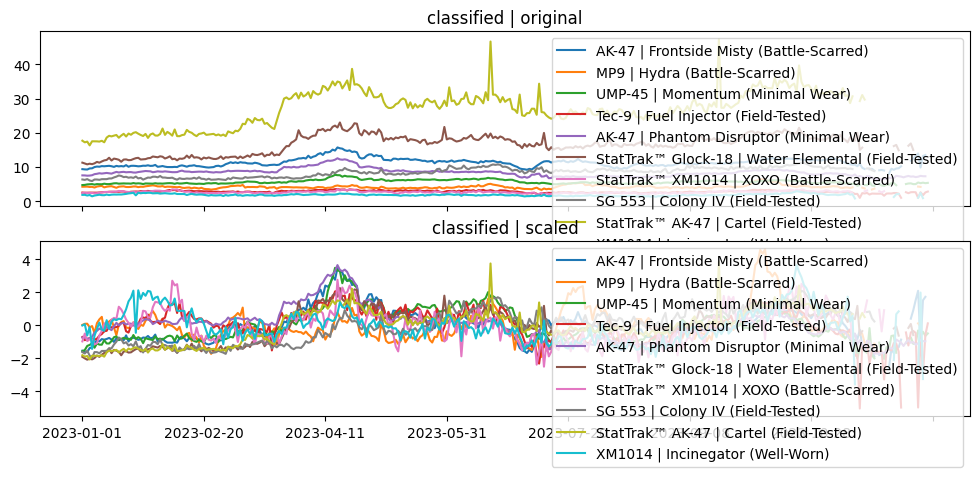

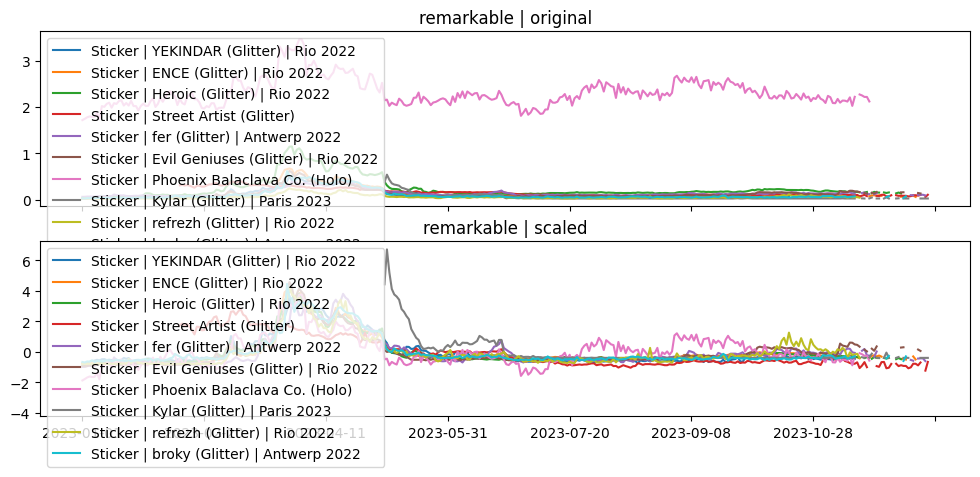

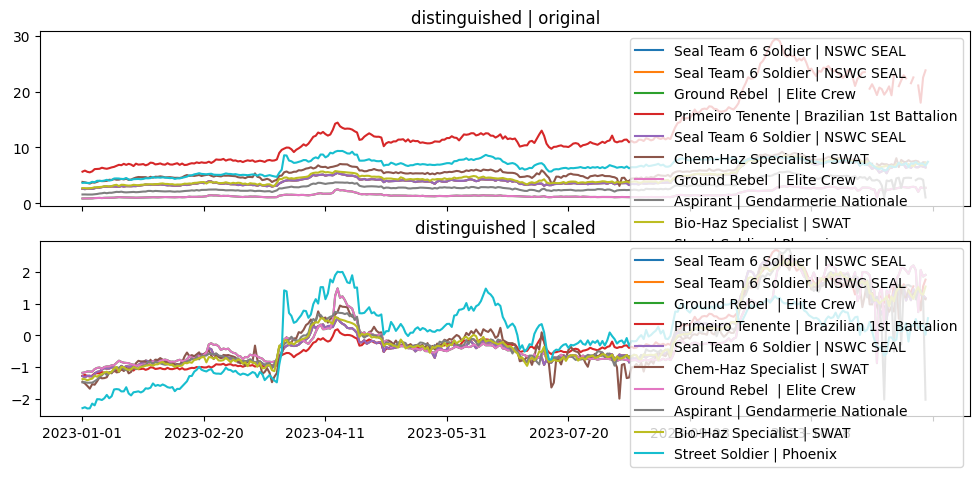

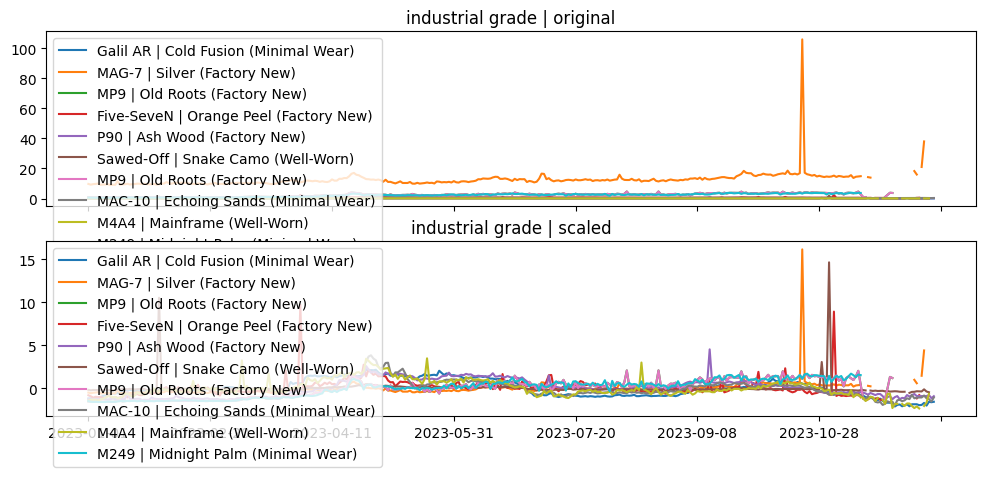

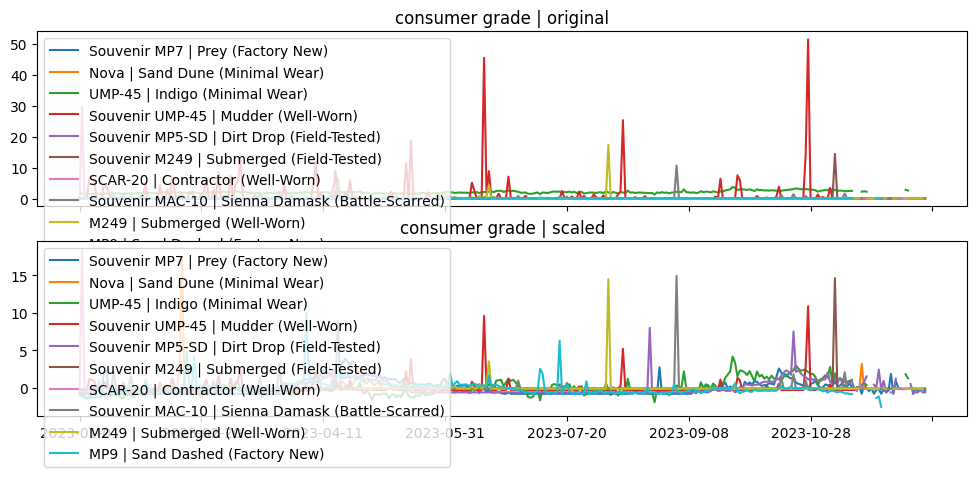

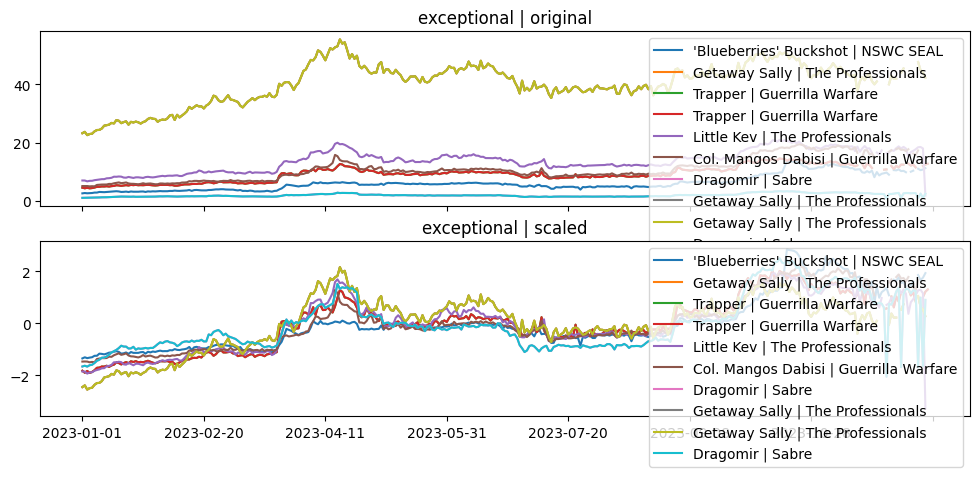

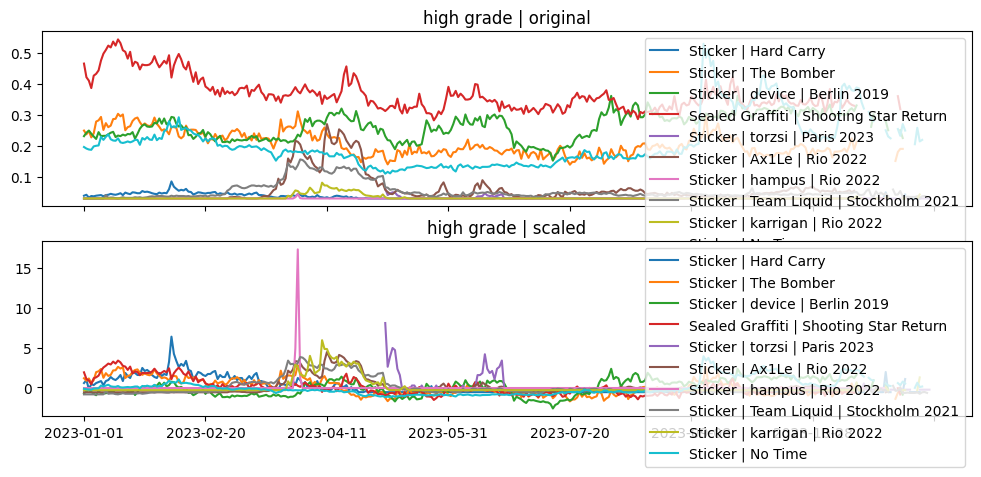

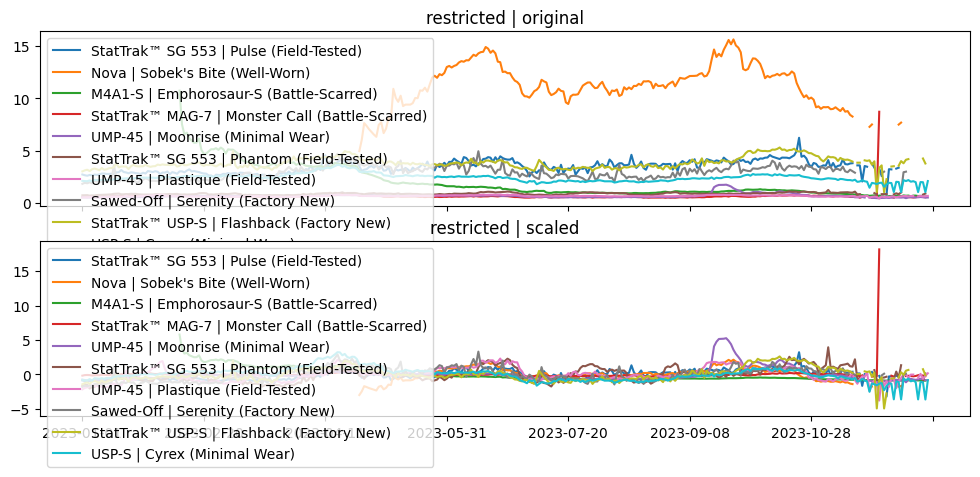

In [ ]:
for feature in set(y_train):
    items_with_feature = y_train==feature
    df_subset = stable_data.loc[:,items_with_feature]
    feature_cols = df_subset.columns
    scaled_subset = pd.DataFrame(X_train[items_with_feature,:,0].T,columns = feature_cols)
    scaled_subset.index = df_subset.index
    random_columns = np.random.choice(feature_cols,size = min(10,len(scaled_subset)))
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
    df_subset[random_columns].plot(ax=axes[0], title =f"{feature} | original")
    scaled_subset[random_columns].plot(ax=axes[1], title =f"{feature} | scaled")

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


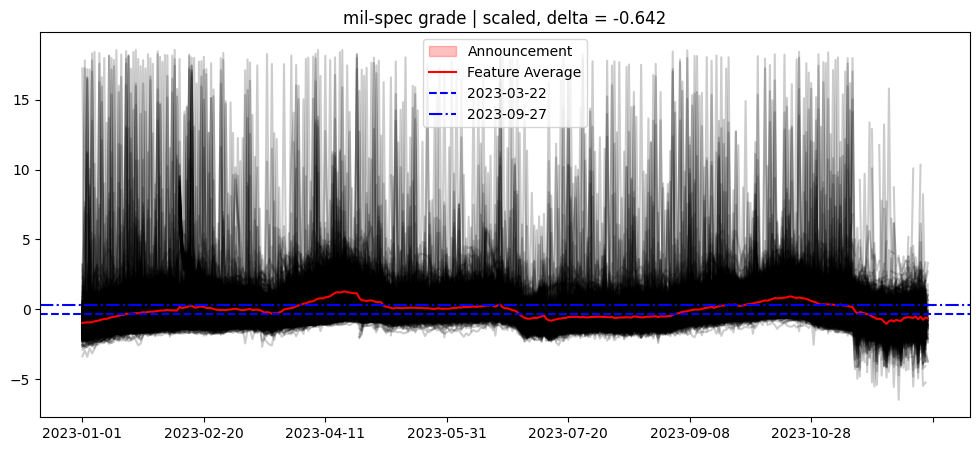

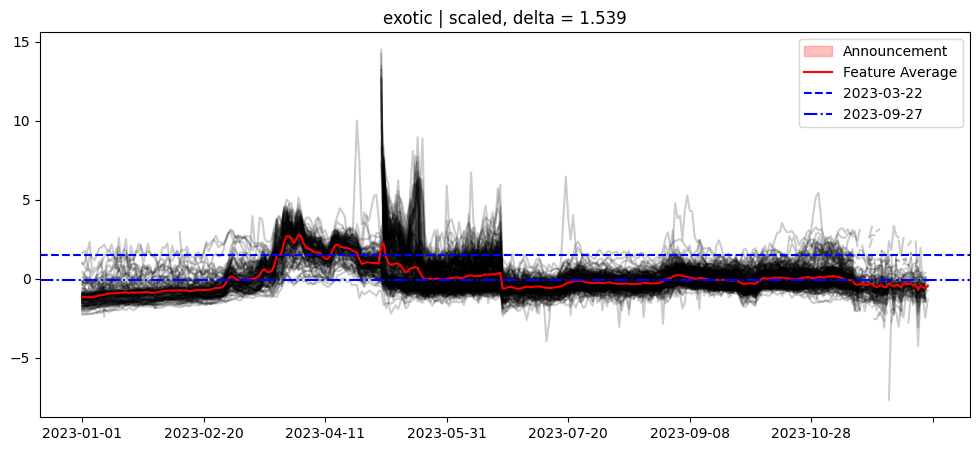

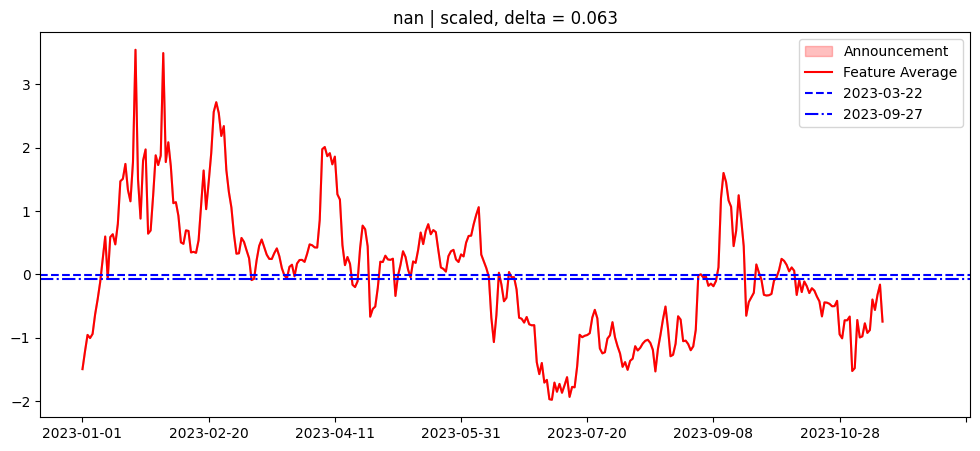

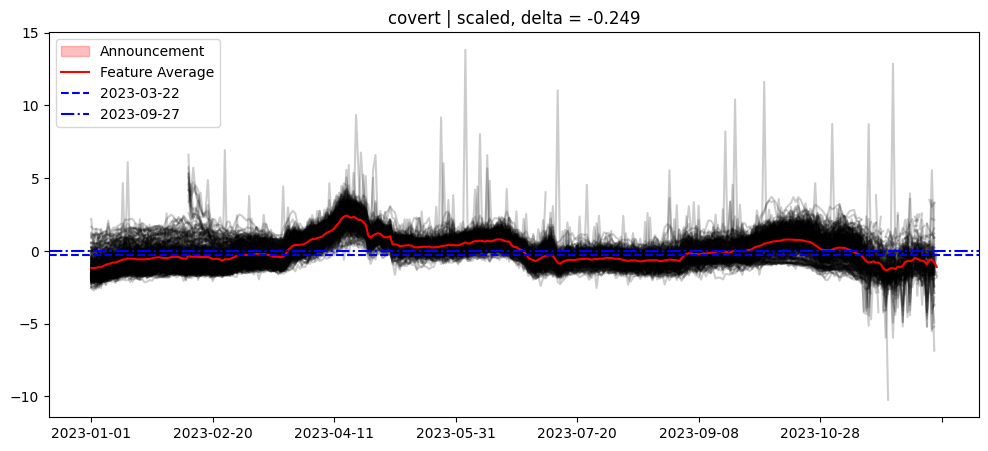

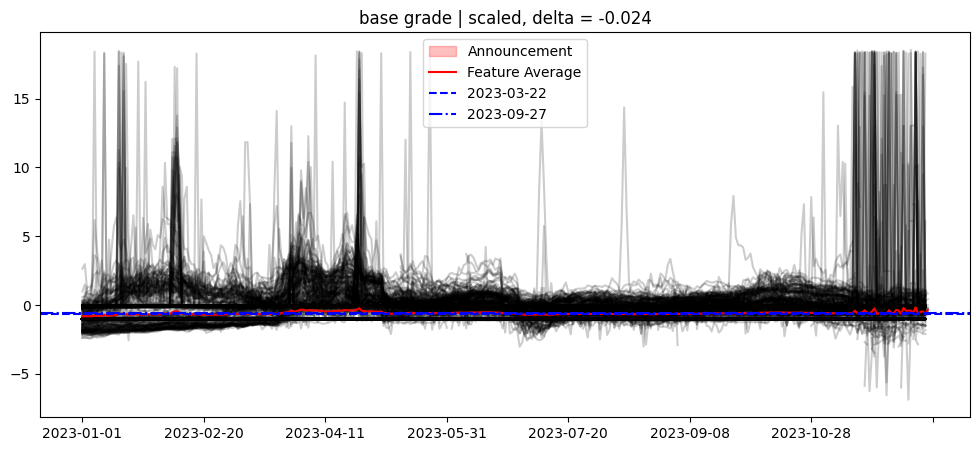

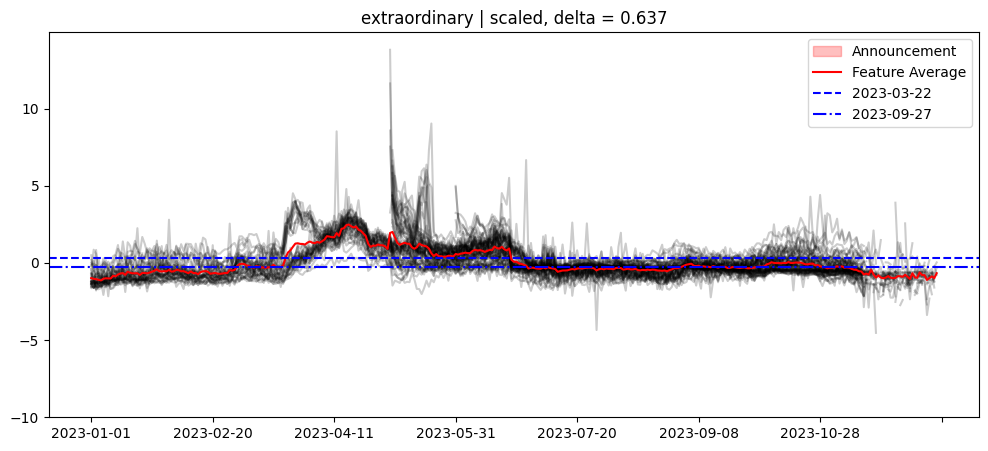

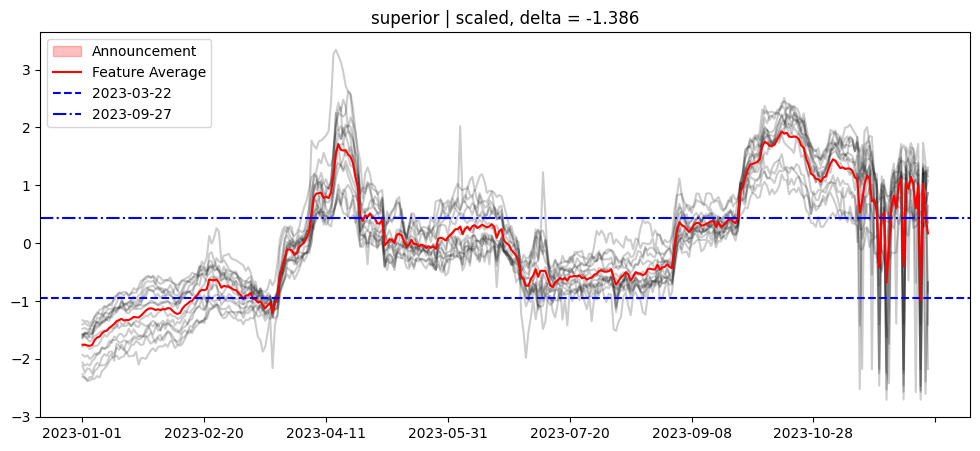

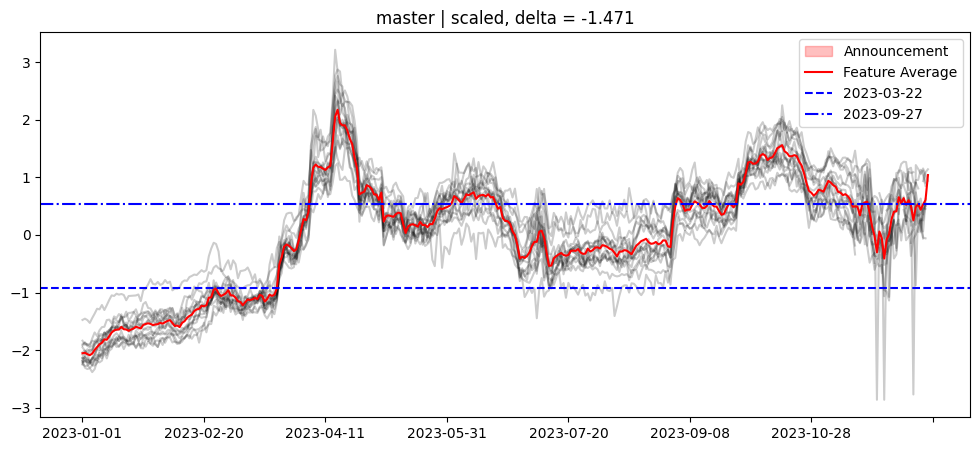

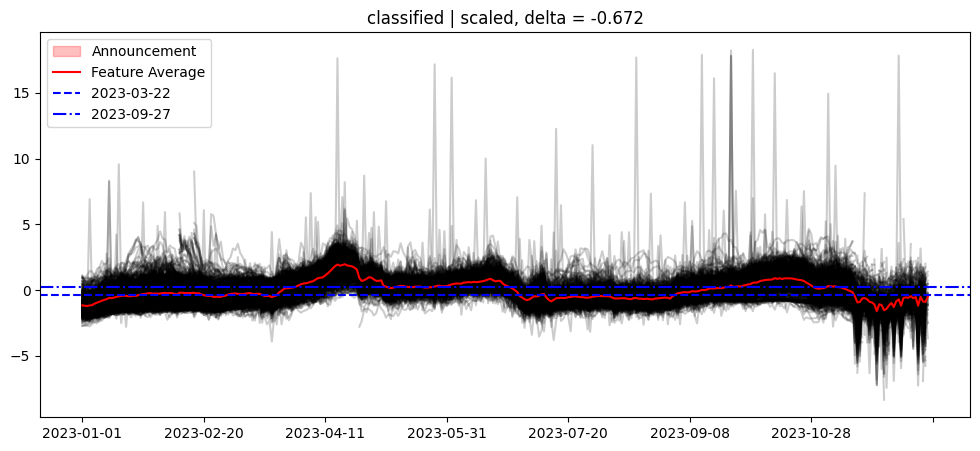

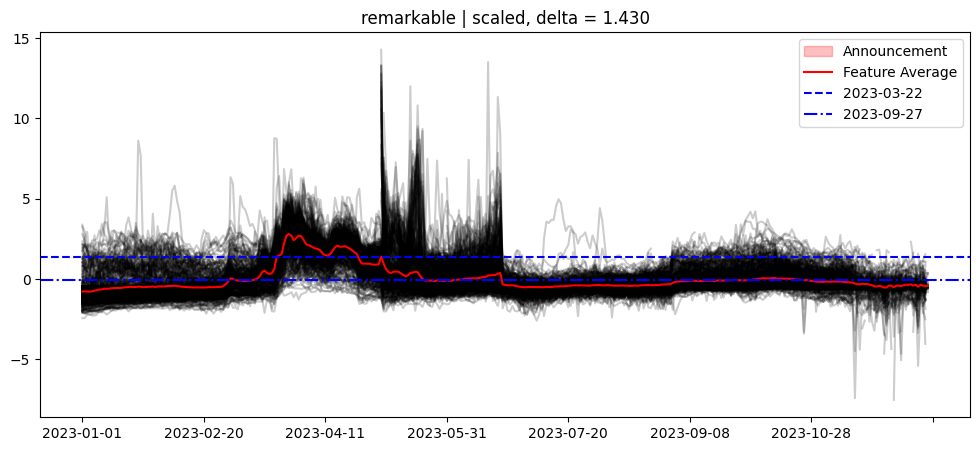

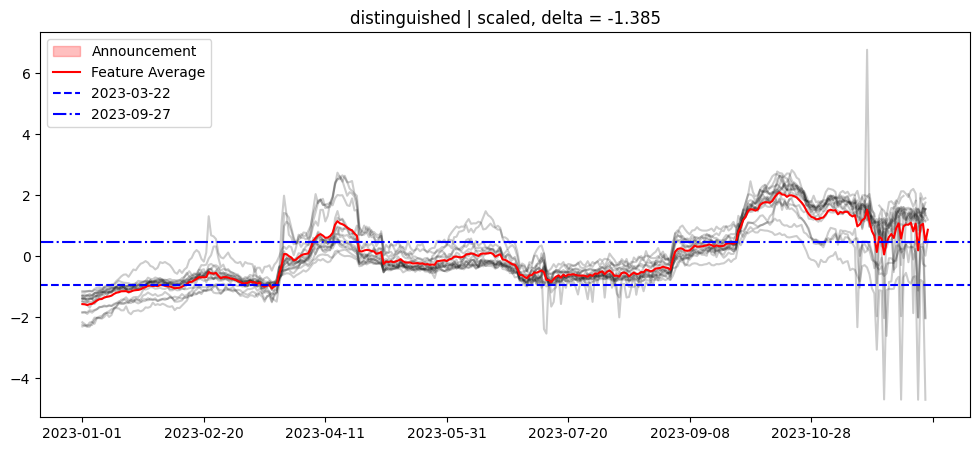

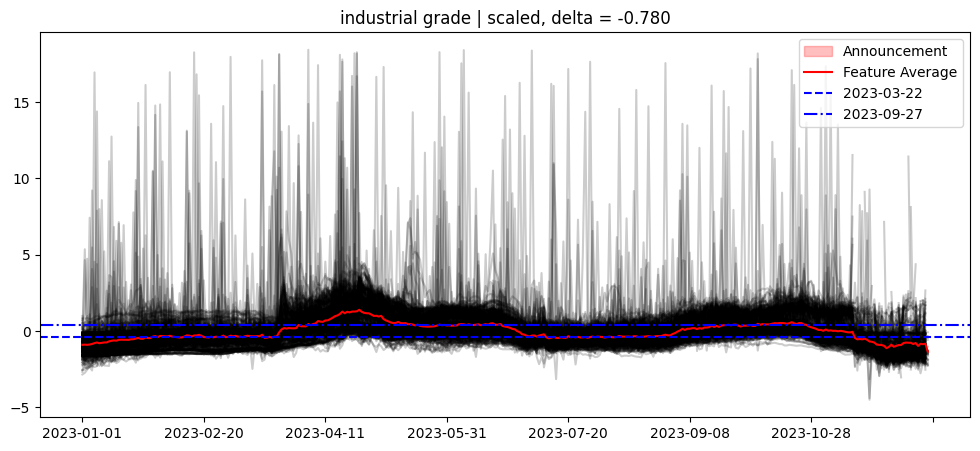

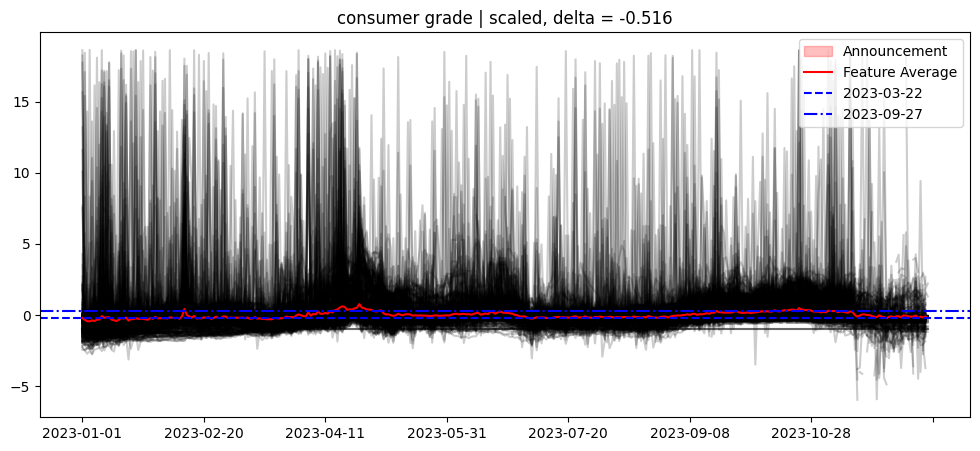

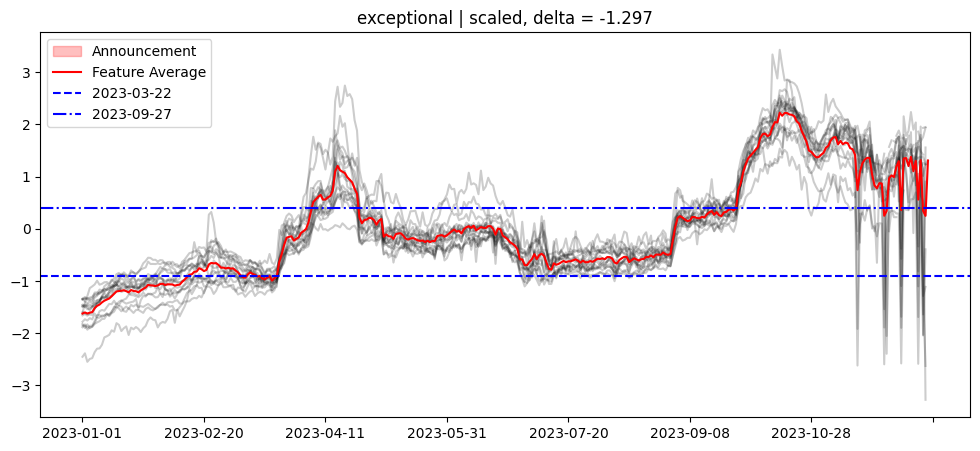

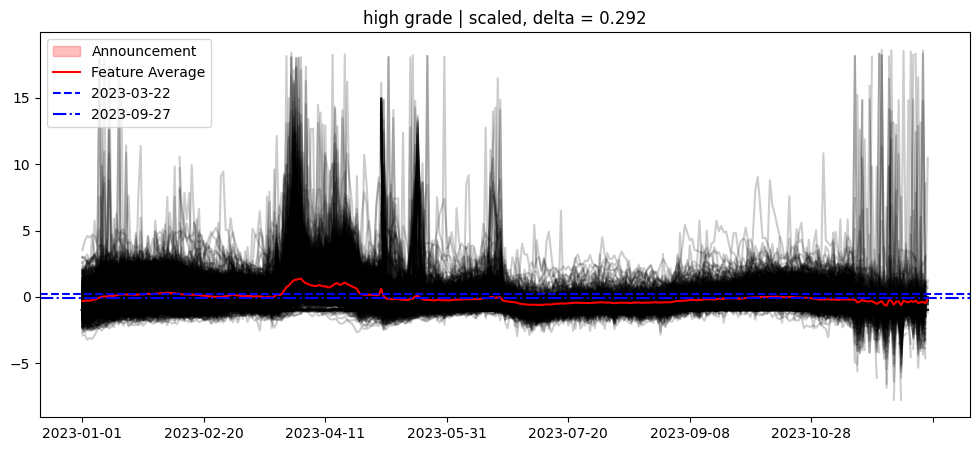

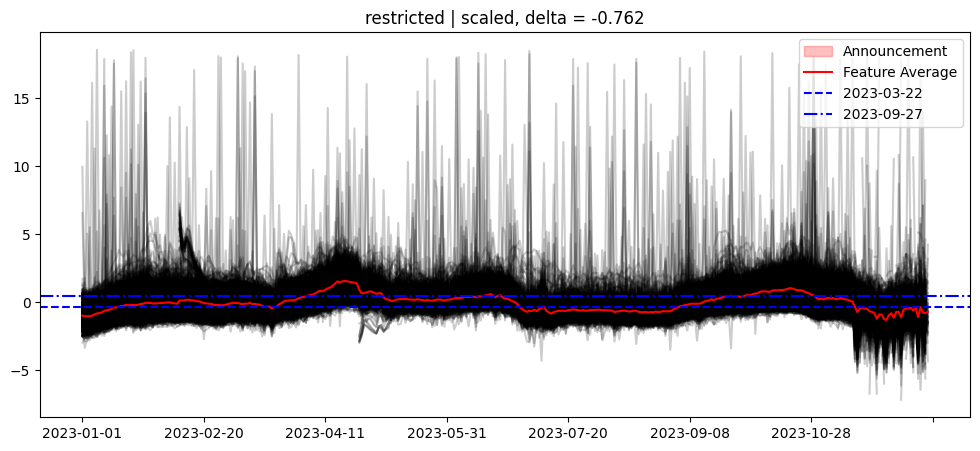

In [ ]:
for feature in set(y_train):
    items_with_feature = y_train==feature
    df_subset = stable_data.loc[:,items_with_feature]
    feature_cols = df_subset.columns
    scaled_subset = pd.DataFrame(X_train[items_with_feature,:,0].T,columns = feature_cols)
    scaled_subset.index = df_subset.index
    val_at_id1 = scaled_subset.mean(axis=1)["2023-03-22"]
    val_at_id2 = scaled_subset.mean(axis=1)["2023-09-27"]
    delta = val_at_id1-val_at_id2
    scaled_subset.plot(title =f"{feature} | scaled, delta = {delta:.3f}", alpha = 0.2, c= "black", legend= False)
    # plt.gca().get_legend().remove()
    # id1 = list(stable_data.index).index(pd.to_datetime("2023-03-22").date())
    area_fill = plt.fill_betweenx(np.arange(scaled_subset.min().min(), scaled_subset.max().max(), 0.01),pd.to_datetime("2023-03-22").date(),pd.to_datetime("2023-09-27").date(),color="red",alpha=0.25, label = "Announcement")
    avg = scaled_subset.mean(axis=1)
    # announce = plt.axvline(datetime(2023, 3, 22), color = 'r', label="Announcement")
    # release = plt.axvline(datetime(2023, 9, 27), color = 'r', label="Release")
    line_a = plt.plot(avg.index, avg, color ="red", label = "Feature Average")
    line2 = plt.axhline(y=val_at_id1, label = "2023-03-22", color = "blue", linestyle = "dashed")
    line3 = plt.axhline(y=val_at_id2, label = "2020-06-30", color = "blue", linestyle = "-.")
    plt.legend([area_fill,line_a[0],line2,line3],["Announcement","Feature Average","2023-03-22","2023-09-27"])
    # plt.savefig(f"../../plots/sector_{sector}_plot.jpeg")

# Case Clustering

In [4]:
# reading data from downloaded csv format from DataCollection.ipynb
# viewing time period starting from 1/1/2023
price = pd.read_csv("CasePrices.csv", index_col=0)["2023":]
volume = pd.read_csv("CaseVolumes.csv", index_col=0)["2023":]

In [5]:
# using the first item for testing
dataPrice = price.iloc[:,0].dropna()
dataVolume = volume.iloc[:,0].dropna()

In [6]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [7]:
price.shape

(345, 36)

In [8]:
X_train = TimeSeriesScalerMeanVariance().fit_transform(price.T)
X_train.shape

(36, 345, 1)

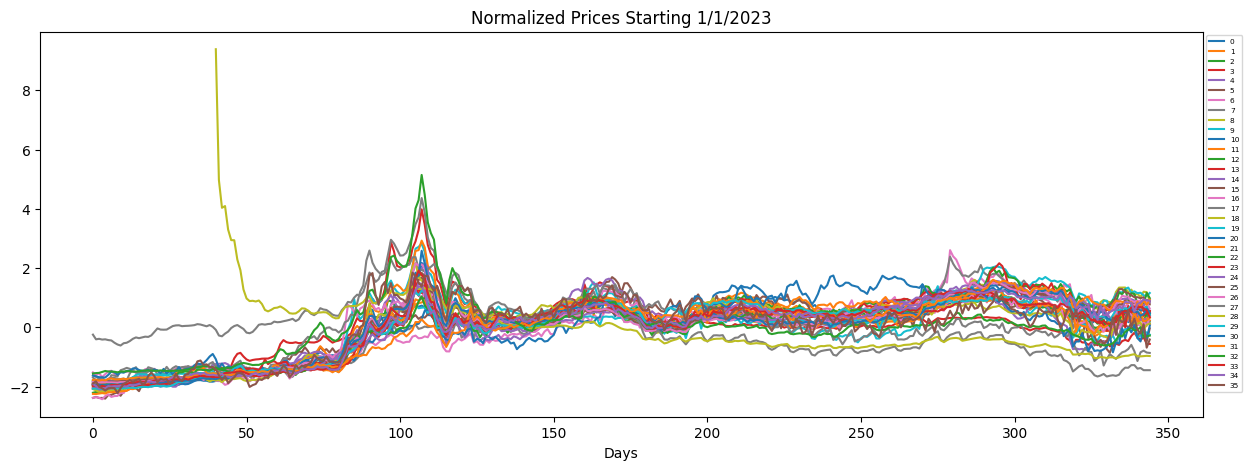

In [9]:
pd.DataFrame(X_train[:,:,0].T).plot(figsize=(15,5))
plt.legend(bbox_to_anchor=(1,1), loc='upper left', fontsize='5.3')
plt.title('Normalized Prices Starting 1/1/2023')
plt.xlabel('Days')
plt.show()

In [17]:
X_train = np.nan_to_num(X_train)

Euclidean k-means
53.441 --> 38.568 --> 37.803 --> 37.227 --> 36.565 --> 32.969 --> 31.662 --> 30.438 --> 29.976 --> 29.725 --> 29.725 --> 
DBA k-means
Init 1


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


13.958 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


6.360 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


6.289 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


6.289 --> 
Init 2


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


13.268 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


6.274 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


6.274 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


Soft-DTW k-means
379.096 --> 30.803 --> 29.172 --> 29.178 --> 29.101 --> 29.121 --> 29.059 --> 29.082 --> 29.059 --> 29.075 --> 29.042 --> 29.059 --> 29.024 --> 29.039 --> 28.996 --> 29.023 --> 28.796 --> 28.746 --> 28.783 --> 28.761 --> 28.797 --> 28.749 --> 28.796 --> 28.739 --> 28.767 --> 28.799 --> 28.743 --> 28.764 --> 28.796 --> 28.836 --> 28.781 --> 28.864 --> 28.776 --> 28.860 --> 28.817 --> 28.860 --> 28.823 --> 28.846 --> 28.791 --> 28.830 --> 28.727 --> 28.784 --> 28.805 --> 28.555 --> 28.747 --> 28.631 --> 28.656 --> 28.604 --> 28.611 --> 28.584 --> 


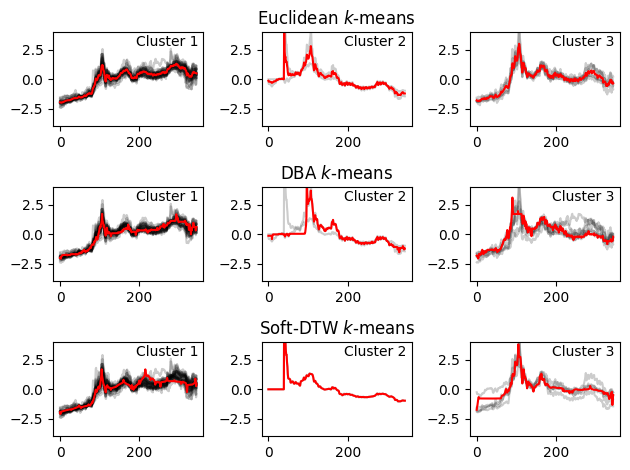

In [19]:
from tslearn.clustering import TimeSeriesKMeans
seed = 0
# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=seed)
y_pred = km.fit_predict(X_train)

plt.figure()
for yi in range(3):
    plt.subplot(3, 3, yi + 1)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    # plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred = dba_km.fit_predict(X_train)

for yi in range(3):
    plt.subplot(3, 3, 4 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    # plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

# Soft-DTW-k-means
print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=3,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=seed)
y_pred = sdtw_km.fit_predict(X_train)

for yi in range(3):
    plt.subplot(3, 3, 7 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
    # plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Soft-DTW $k$-means")

plt.tight_layout()
plt.show()